<center><h1>1-e: Transformer</h1></center>
<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>


# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.

In this notebook, we will implement the first Visual Transformer, [ViT](https://arxiv.org/abs/2010.11929). We'll implement a naive version of it, much smaller than the ones described in the paper, and we also won't use complex data augmentation and regularizations. But note that this is important to make transformers work in practice on large-scale dataset.

To get a gist of what is required to make a transformer work in practice, have a look at the [DeiT and CaiT codebase](https://github.com/facebookresearch/deit).

This notebook is a simplified version of the excellent [Timm library](https://github.com/rwightman/pytorch-image-models).

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:





import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image

Let's load the MNIST dataset:

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

100%|██████████| 9912422/9912422 [00:00<00:00, 246822155.99it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 87970728.99it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 150679580.74it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22177565.50it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



... and visualize!

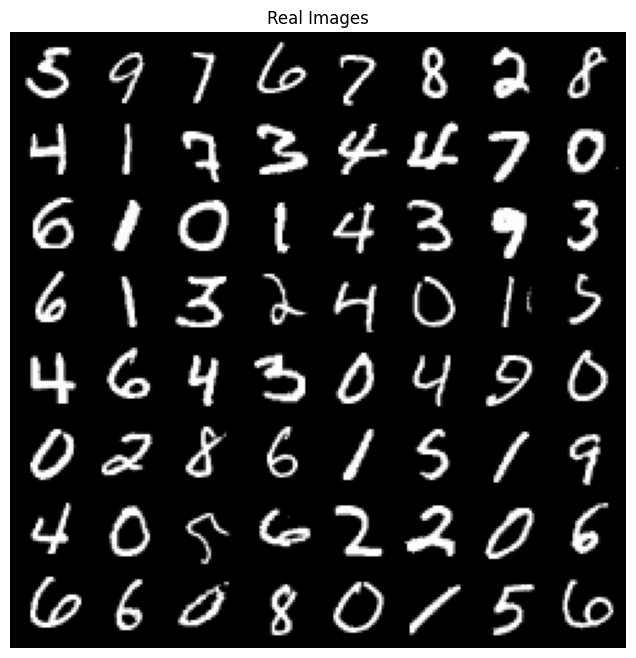

In [ ]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

# Here is the general architecture of the ViT model
## The architecture includes:
- A step for splitting the image into disjoint patches with a linear projection of the patches
- Positional encoding to capture the absolute spatial information of each patch in the image
- The addition of a "[CLS]" token, initialized randomly and learned during training
- A transformer encoder that learns the representation of each token
- A classification head that performs class prediction from the re-embedded [CLS] token at the output of the encoder

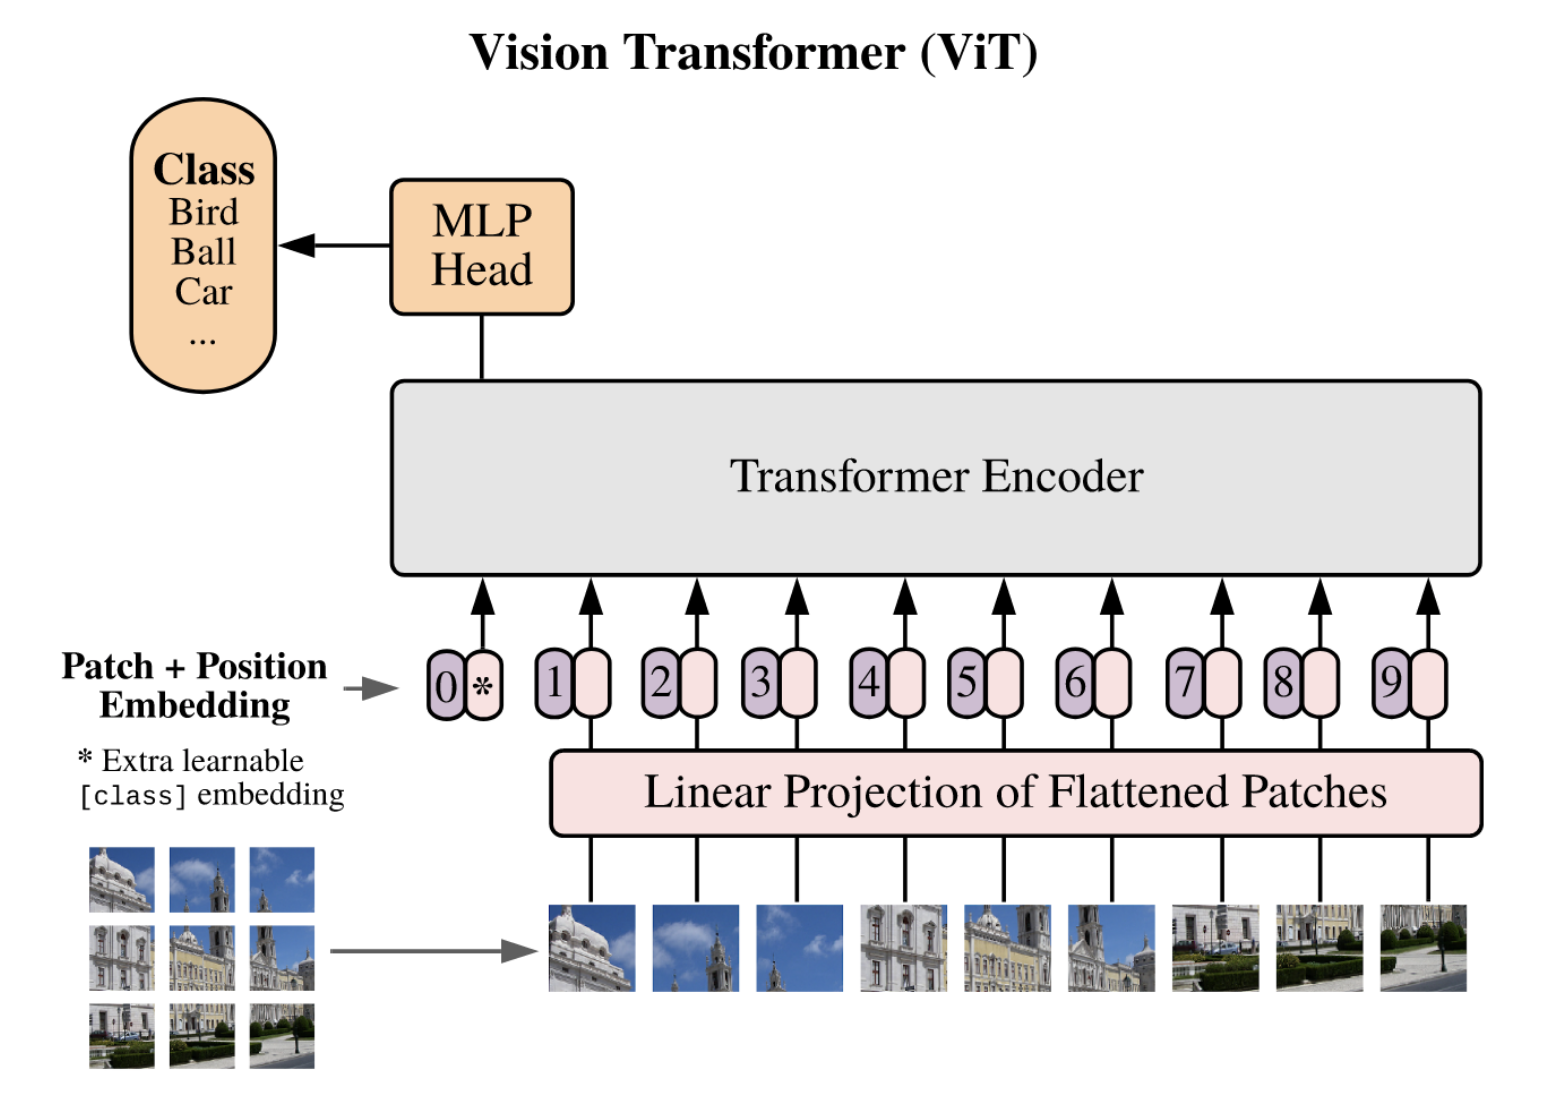

**Q1**:
First, we need to code the patch embedding. In NLP, it could be using a word2vec embeddings, but we need something different in Computer Vision.

You are going to use a 2d convolution (called "Linear Projection" on the image above) to process each patch independently without overlap. Think a bit how you could do that.

Then, you need to manipulate the dimensions of the resulting tensor to get a final tensor of shape `(batch_size, nb_tokens, embedding_dim)`. *Hint: You will need a `view/reshape` and `transpose/permute` operators*.

As usual, remember to check the output shape of your layer by trying with a random tensor!

In [ ]:
class PatchEmbed(nn.Module):
    def __init__(self, in_chan=1, patch_size=7, embed_dim=128):
        super().__init__()
        # Using a convolutional layer to break the image into patches and embed them
        self.projection = nn.Conv2d(in_chan, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # Applying the projection (convolutional layer)
        x = self.projection(x)

        # Reshaping the tensor for transformer
        B, C, H, W = x.shape
        #print(B, C, H, W)
        x = x.permute(0, 2, 3, 1)  # Change the order of dimensions to B, H, W, C
        x = x.reshape(B, H * W, C) # Flatten the H and W dimensions

        return x

PatchEmbed()(torch.randn(32, 1, 7, 128)).shape

torch.Size([32, 18, 128])

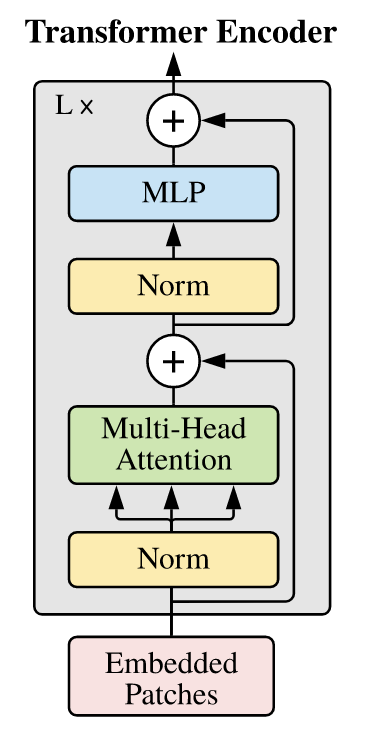

## Q2 : MLP
Now we need to build a transformer block. Let's first build the easiest part, the MLP! By now, you should be confident how to code one.

Code a MLP with one hidden layer. Note that the input and output dimensions will be the same. Instead of ReLU, use the activation GELU, which is a slight alternative often used for transformers.

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_features, hid_features):
        super().__init__()

        # Two linear layers with GELU activation in between
        self.fc1 = nn.Linear(in_features, hid_features)
        self.fc2 = nn.Linear(hid_features, in_features)
        self.dropout = nn.Dropout(0.0)  # Optional: Add dropout for regularization

    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

net = MLP(128, 512)
net(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

## Q3: Self-attention

Now we are going to build the famous **Self-Attention**.
- What is the main feature of self-attention, especially compared to its convolutional counterpart. What is its main challenge in terms of computation/memory?
- At first, we are going to only consider the simple case of one head. Write the equations and complete the following code. And don't forget a final linear projection at the end!




In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()

        # Define the projections for Query, Key, and Value
        self.W_Q = nn.Linear(embed_dim, embed_dim)
        self.W_K = nn.Linear(embed_dim, embed_dim)
        self.W_V = nn.Linear(embed_dim, embed_dim)

        # Define the final projection
        self.W_O = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.shape

        # TODO: compute the Q, K, V
        q = self.W_Q(x)
        k = self.W_K(x)
        v = self.W_V(x)

        # TODO: compute the attention matrix using Q and K
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(C)
        attention = F.softmax(scores, dim=-1)

        # TODO: compute the final version using the attention,
        # V, and the final projection
        out = torch.matmul(attention, v)
        x = self.W_O(out)

        return x

SelfAttention(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q4 : Multi-head self-attention
Now we need to build a Multi-Heads Self-Attention.
- Write the equations and complete the following code to build a Multi-Heads Self-Attention.
- The total embedding size will be shared equally among all heads.

In [ ]:
class MultiHeadsSelfAttention(SelfAttention):
    def __init__(self, embed_dim, num_heads):
        super().__init__(embed_dim)

        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        head_dim = embed_dim // num_heads
        self.scale = head_dim ** -0.5
        self.num_heads = num_heads

    def forward(self, x):
        B, N, C = x.shape

        q = self.W_Q(x).view(B, N, self.num_heads, C // self.num_heads)
        k = self.W_K(x).view(B, N, self.num_heads, C // self.num_heads)
        v = self.W_V(x).view(B, N, self.num_heads, C // self.num_heads)

        # Transpose to get dimensions (B, num_heads, N, head_dim)
        q, k, v = map(lambda t: t.transpose(1, 2), (q, k, v))

        # Compute attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attention = F.softmax(scores, dim=-1)

        # Apply attention to values
        out = torch.matmul(attention, v)

        # Transpose to get dimensions (B, N, num_heads, head_dim)
        out = out.transpose(1, 2).contiguous()

        # Reshape to get dimensions (B, N, C)
        out = out.view(B, N, C)

        # Project to output dimension
        x = self.W_O(out)

        return x

x = torch.randn(32, 16, 6)  # we need to match embed_dims parameters
MultiHeadsSelfAttention(6, 2)(x).shape

torch.Size([32, 16, 6])

# Q5: Transfomer block

Now, we need to build a Transformer **Block** as described in the image below.
- Write the equations and complete the following code.
- For the Layer Normalization, use PyTorch LayerNorm: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

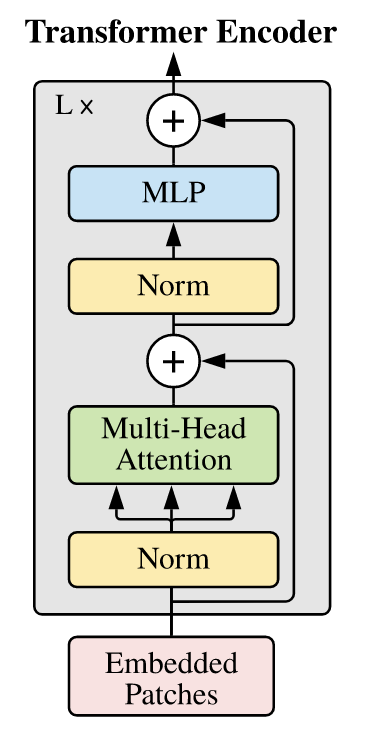

In [ ]:
class Block(nn.Module):
    def __init__(self, embed_dim, num_heads=6, mlp_ratio=4):
        super().__init__()

        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = MultiHeadsSelfAttention(embed_dim, num_heads)

        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_ratio * embed_dim),
            nn.GELU(),
            nn.Linear(mlp_ratio * embed_dim, embed_dim),
            nn.Dropout(0.0)  # Optional: Add dropout for regularization
        )

    def forward(self, x):
        # Applying the Multi-Head Self-Attention
        attention_out = self.attention(self.norm1(x)) + x

        # Applying the Position-wise Feed-Forward Network
        x = self.mlp(self.norm2(attention_out)) + attention_out

        return x

Block(128, num_heads=8)(torch.randn(32, 16, 128)).shape # embed_dim (128) is not divisible by num_heads (6), so we need to change num_heads to make embed_dim divisible entirely

torch.Size([32, 16, 128])

# Q6: Full ViT model

Now you need to build a ViT model based on what you coded in the previous questions. There are additional components that should be coded such as the Class token, Positional embedding and the classification head.

- Explain what is a Class token and why we use it? \\
- Explain whay is the the positional embedding (PE) and why it is important? \\

For PE, you can use a sinusoidal encoding (see below), or fully learned.

### Sinusoidal PE


In [ ]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(1,sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[0][i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [ ]:
class ViT(nn.Module):
    def __init__(self, embed_dim, nb_blocks, patch_size, nb_classes=10, num_heads=4): # we add a num_heads parameter because of the MHSA module which needs specific conditions to work
        super().__init__()

        num_patches = (28 // patch_size) ** 2

        self.class_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        self.patch_embed = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)

        blocks = []
        for _ in range(nb_blocks):
            blocks.append(Block(embed_dim, num_heads=num_heads))
        self.blocks = nn.Sequential(*blocks)

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, nb_classes)

    def forward(self, x):
        x = self.patch_embed(x)  # image to patches

        # concatenating class token
        class_token = self.class_token.expand(x.size(0), -1, -1)  # Expanding the class token to match the batch size
        x = torch.cat((class_token, x), dim=1)

        # adding positional embedding
        x = x + self.pos_embed

        # forward in the transformer
        x = self.blocks(x)

        # Normalize the output
        x = self.norm(x)

        # Taking the representation corresponding to the class token
        # (which is at index 0) and passing it through the classification head
        output = self.head(x[:, 0])

        return output

ViT(768, 3, 7)(torch.randn(32, 1, 28, 28)).shape

torch.Size([32, 10])

# Q7: Experiment on MNIST!

A quick function to evaluate our model:

In [ ]:
@torch.no_grad()
def eval_model(model, loader):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

And run! Feel free to try other hyperparameters.

In [ ]:

from tqdm import tqdm

def exp(epochs = 10,
        embed_dim = 32, # 768 for embed_dim and num_heads=12 to be more similar to the model we will see later
        patch_size = 7,
        nb_blocks = 2):


  model = ViT(embed_dim, nb_blocks, patch_size).cuda()
  opt = torch.optim.Adam(model.parameters())

  acc_train_list = []
  loss_train_list = []
  loss_test_list = []

  for epoch in tqdm(range(epochs)):
    train_loss = 0.
    for x, y in train_loader:
      x, y = x.cuda(), y.cuda()

      opt.zero_grad()
      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      loss.backward()

      opt.step()

      train_loss += loss.item()
    loss_train_list.append(train_loss / len(train_loader))
    acc_train_list.append(eval_model(model, train_loader))

    if(0== 0):
      for x, y in test_loader:
        x, y = x.cuda(), y.cuda()
        yhat = model(x)
        loss += F.cross_entropy(yhat, y)
      loss_test_list.append((loss / len(test_loader)).cpu().item())

  return acc_train_list, loss_train_list, loss_test_list



# Experimental analysis
- Test different hyperparameters and explain how they affect the performance. In particular embed_dim, patch_size, and nb_blocks.
- Comment and discuss the final performance that you get. How to improve it?
-  What is the complexity of the transformer in terms of number of tokens? How you can improve it?

100%|██████████| 10/10 [03:00<00:00, 18.02s/it]


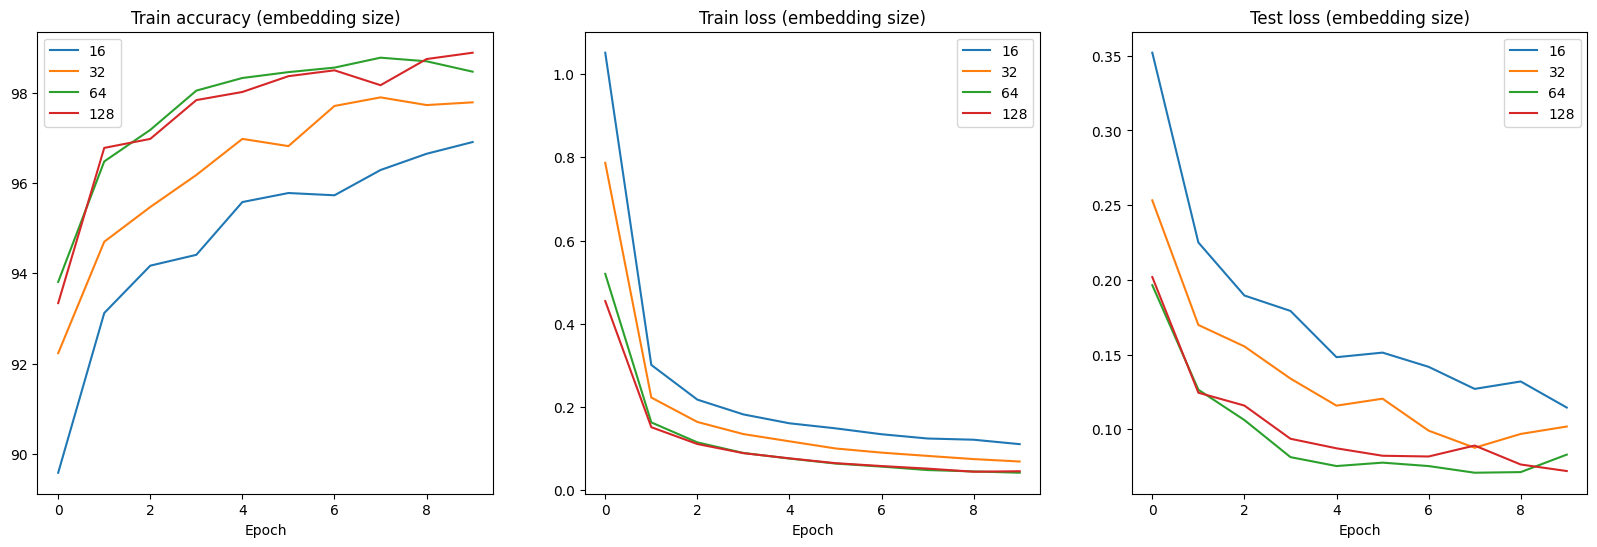

In [ ]:
import matplotlib.pyplot as plt
embed_dims = [16,32,64,128]
acc = []
ltr = []
lte = []
for embed in embed_dims:
  acctrain, loss_train, loss_test = exp(embed_dim = embed)
  acc.append(acctrain)
  ltr.append(loss_train)
  lte.append(loss_test)



plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
plt.title('Train accuracy (embedding size)')
plt.xlabel('Epoch')
for i in range(len(acc)):
  plt.plot(acc[i], label = str(embed_dims[i]))
  plt.legend(prop={"size": 10})

plt.subplot(1,3,2)
plt.title('Train loss (embedding size)')
plt.xlabel('Epoch')
for i in range(len(acc)):
  plt.plot(ltr[i], label = str(embed_dims[i]))
  plt.legend(prop={"size": 10})

plt.subplot(1,3,3)
plt.title('Test loss (embedding size)')
plt.xlabel('Epoch')
for i in range(len(acc)):
  plt.plot(lte[i], label = str(embed_dims[i]))
  plt.legend(prop={"size": 10})

In [ ]:
patch_size = [2,4,7,14, 28]
acc = []
ltr = []
lte = []
for p in patch_size:
  acctrain, loss_train, loss_test = exp(patch_size = p)
  acc.append(acctrain)
  ltr.append(loss_train)
  lte.append(loss_test)



plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
plt.title('Train accuracy (Patch size)')
plt.xlabel('Epoch')
for i in range(len(acc)):
  plt.plot(acc[i], label = str(patch_size[i]))
  plt.legend(prop={"size": 10})

plt.subplot(1,3,2)
plt.title('Train loss (Patch size)')
plt.xlabel('Epoch')
for i in range(len(acc)):
  plt.plot(ltr[i], label = str(patch_size[i]))
  plt.legend(prop={"size": 10})

plt.subplot(1,3,3)
plt.title('Test loss (Patch size)')
plt.xlabel('Epoch')
for i in range(len(acc)):
  plt.plot(lte[i], label = str(patch_size[i]))
  plt.legend(prop={"size": 10})

  0%|          | 0/10 [00:33<?, ?it/s]


OutOfMemoryError: ignored

In [ ]:
nb_blocks = [2,4,6,8]
acc = []
ltr = []
lte = []
for n in nb_blocks:
  acctrain, loss_train, loss_test = exp(nb_blocks = n)
  acc.append(acctrain)
  ltr.append(loss_train)
  lte.append(loss_test)



plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
plt.title('Train accuracy (nb blocks)')
plt.xlabel('Epoch')
for i in range(len(acc)):
  plt.plot(acc[i], label = str(patch_size[i]))
  plt.legend(prop={"size": 10})

plt.subplot(1,3,2)
plt.title('Train loss (nb blocks)')
plt.xlabel('Epoch')
for i in range(len(acc)):
  plt.plot(ltr[i], label = str(patch_size[i]))
  plt.legend(prop={"size": 10})

plt.subplot(1,3,3)
plt.title('Test loss (nb blocks)')
plt.xlabel('Epoch')
for i in range(len(acc)):
  plt.plot(lte[i], label = str(patch_size[i]))
  plt.legend(prop={"size": 10})

  0%|          | 0/10 [00:16<?, ?it/s]


OutOfMemoryError: ignored

# Q8: larger transformers

Try to use bigger transformer, for example the ViT-S from the timm library. Test with and without intialization from imagenet.

In [ ]:
!pip install timm

a) Load the model using the timm library without pretrained wewights. Try to apply it directly on a tensor with the same MNIST images resolution. What it is the problem and why we have it? Explain if we have also such problem with CNNs. As ViT takes RGB images, the input tensor should have 3 channels.

In [ ]:
import timm

model = timm.create_model("vit_small_patch16_224", pretrained=False, num_classes=10, in_chans=1)  # in_chans=1 for MNIST images' levels of gray

In [ ]:
# Create a random tensor with MNIST image resolution
x = torch.randn(32, 1, 28, 28)

# Resize the images to 224x224 (this solves the problem, ViT-S standard model takes 224x224 inputs)
x_resized = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
model(x_resized).shape

b) There is a trick in timm that allows to use pretrained models with different image resolution and number of classes. Try to reload the model to be able to use on MNIST images:

In [ ]:
# Load the model with customized input resolution and number of classes, thanks to pretrained ViT-S model
model = timm.create_model("vit_small_patch16_224", pretrained=True, img_size=28, in_chans=3, num_classes=10) # embed_dim = 768 and num_heads = 12 in this model, putting embed_dim = 128 and num_heads = 8 as the model defined before seems to break the model construction
model(torch.randn(32, 3, 28, 28)).shape

c) redo the training with the pretrained ViT-S





In [ ]:
@torch.no_grad()
def eval_model(model, loader, num_channels=1):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    x = x.repeat(1, 3, 1, 1) # adapt number of channels to fit in ViT

    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

In [ ]:
import timm

model.cuda()
model.train()

epochs = 10

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    x = x.repeat(1, 3, 1, 1) # adapt number of channels to fit in ViT
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")

acc = eval_model(model, test_loader, num_channels=3)
print(f"Test accuracy: {acc}")

--- Epoch 0 ---
Train loss: 0.6353166841748935


KeyboardInterrupt: ignored

c) redo the training but with the ViT-S pretrained on ImageNet

Let's verify if there's any model that has been trained on ImageNet-21k:

In [ ]:
model_names = timm.list_models(pretrained=True)
vit_small_models = [name for name in model_names if "vit_small" in name]
img21k_small = [name for name in vit_small_models if "_in21k" in name]
print(img21k_small)

As we can see, we have the model 'vit_small_patch16_224.augreg_in21k' which has been trained on ImageNet-21k, but not fine-tuned. That suits perfectly for our case.

In [ ]:
model = timm.create_model("vit_small_patch16_224.augreg_in21k", pretrained=True, img_size=28, in_chans=3, num_classes=10)

model.cuda()

epochs = 10

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    x = x.repeat(1, 3, 1, 1) # adapt number of channels to fit in ViT
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
acc = eval_model(model, test_loader, num_channels=3)
print(f"Test accuracy: {acc}")

d) Comment the final results and provide some ideas on how to make transformer work on small datasets. You can take inspiration from some recent work.